- Filename: Eval-TrajOverview_Plot-Fig5.ipynb
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: June 2023
- Last updated: Mar 26th 2024
- Description: Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., used to produce Figure 5

# Visualizing examplary trajectories from the "best guess" simulations for selected neutral, winter, and summer type regions

## 1. General Settings

In [1]:
from glob import glob

import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import utils
from utils import ColorSettings as cparams


In [2]:
utils.print_imported_package_versions(globals())

xarray==2022.12.0
matplotlib==3.6.2
numpy==1.24.1


## 2. Loading Data

In [3]:
regionmaskpath = ('../data-proc/domain/MEDregions.nc')
regionmask = xr.open_dataset(regionmaskpath).rename({'jm': 'y', 'im': 'x'})

gridpath = ('../data-orig/mesh_mask.nc')
grid = xr.open_dataset(gridpath, drop_variables=('x', 'y'))

Mask_MedSea_reload = xr.open_dataset('../data-proc/domain/Mask_MedSea.nc')

In [4]:
datapath_reg1 = '../data-proc/traj/SubReg9/'
trajpaths_reg1 = sorted(
    glob(
        (
            f'{datapath_reg1}Parcels_CalcTraj_Data-coupled-sd_Release-SubReg9-'
            f't*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'
        )
    ),
    key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_reg1 = xr.open_mfdataset(trajpaths_reg1,
                              concat_dim="start", combine="nested",
                              engine="zarr")

datapath_reg2 = '../data-proc/traj/GulfOfLion/'
trajpaths_reg2 = sorted(
    glob(
        (
            f'{datapath_reg2}Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-'
            f't*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'
        )
    ),
    key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_reg2 = xr.open_mfdataset(trajpaths_reg2,
                              concat_dim="start", combine="nested",
                              engine="zarr")

datapath_reg3 = '../data-proc/traj/SubReg14/'
trajpaths_reg3 = sorted(
    glob(
        (f'{datapath_reg3}Parcels_CalcTraj_Data-coupled-sd_Release-SubReg14-'
         f't*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'
        )
    ),
    key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_reg3 = xr.open_mfdataset(trajpaths_reg3,
                              concat_dim="start", combine="nested",
                              engine="zarr")

## 3. Additional analyses

In [5]:
# build mask distinguishing between the 3 regions:
# neutral, winter, and summer type
# derived manually from Supplementary Figure 1

tmp = regionmask.regs.copy()
for i in [4, 14]:
    # summer type regions
    tmp = tmp.where((regionmask.regs != i), other=-3)

for i in [2, 6, 7, 8, 9, 10, 11, 13, 15, 16]:
    # neutral type regions
    tmp = tmp.where((regionmask.regs != i), other=-2)

for i in [1, 3, 5, 12]:
    # winter type regions
    tmp = tmp.where((regionmask.regs != i), other=-1)

regionmask2 = tmp.where(Mask_MedSea_reload.Mask_MedSea == 1)

## 4. Visualization (Figure 5)

In [6]:
# define plotting parameters

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0, 10, 20, 30]
yticks = [35, 40, 45]
xticklabs = ['0° E', '10° E', '20° E', '30° E']
yticklabs = ['35° N', '40° N', '45° N']

fs = 'xx-small'

col_blue = cparams.blue
col_yellow = cparams.yellow


In [7]:
# define custom plotting functions

def plot_trajectories(release_name):
    if release_name == 'GulfOfLion':
        traj_csd = traj_reg2
        traj_col = col_blue
    if release_name == 'SubReg14':
        traj_csd = traj_reg3
        traj_col = col_yellow
    if release_name == 'SubReg9':
        traj_csd = traj_reg1
        traj_col = (50/255, 50/255, 50/255)
    for i in np.arange(0, 1100, 10):
        for j in np.arange(0, 72, 18):
            plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(
                start=j, trajectory=i), color=traj_col, linewidth=0.3)
            plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(
                start=j, trajectory=i), color=traj_col, linewidth=0.3)

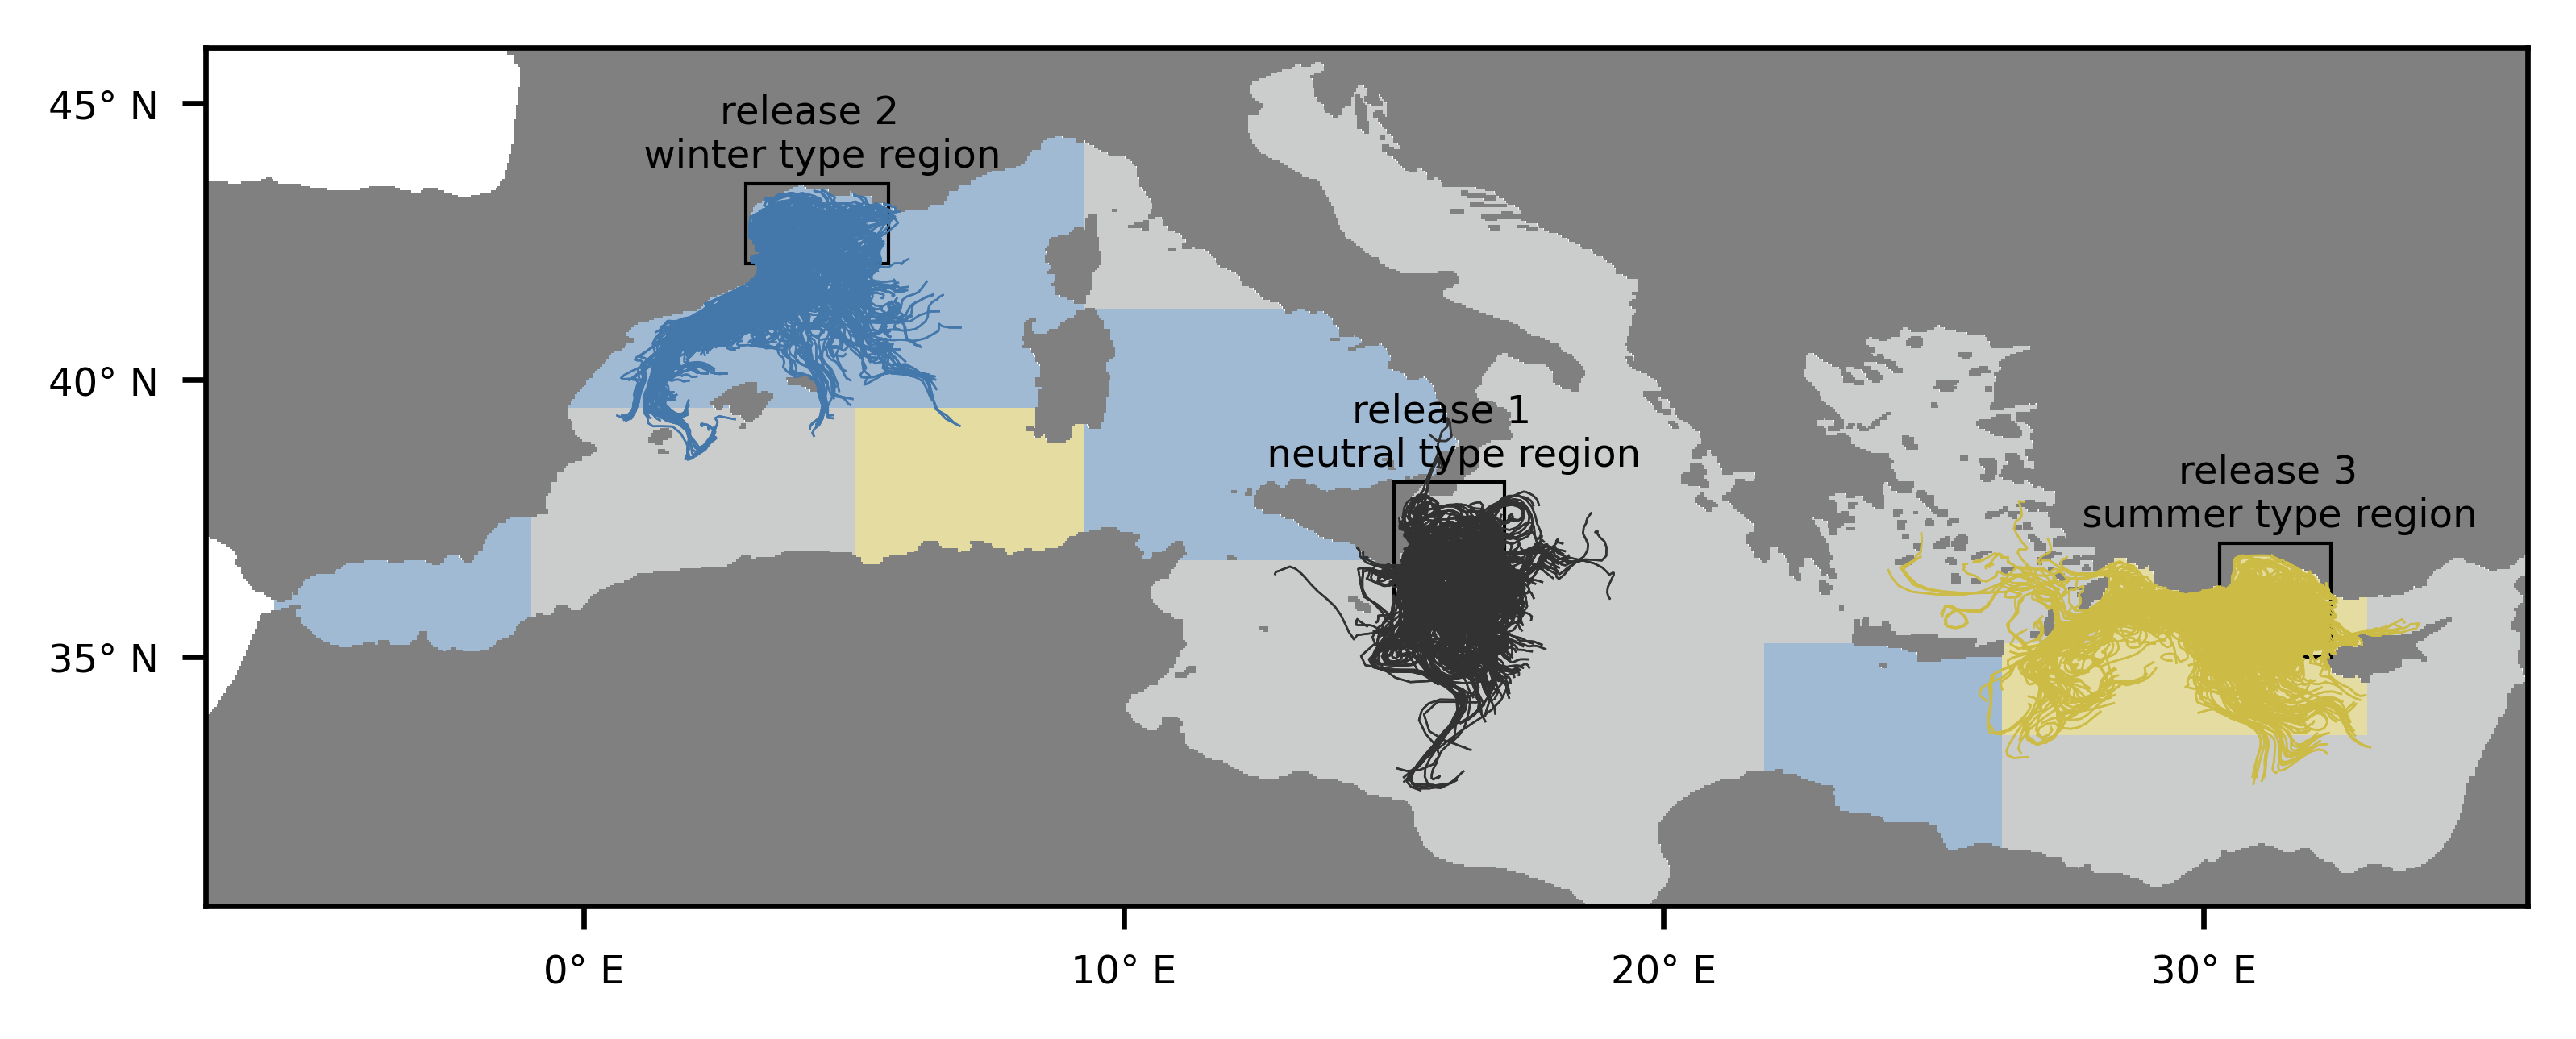

In [9]:
# do plotting

fig = plt.figure(figsize=(6, 6), dpi=600, constrained_layout=False)

gs = fig.add_gridspec(nrows=5, ncols=5,
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)

ax = fig.add_subplot(gs[0:2, 0:6])

# shade background (neutral vs winter vs summer type)
# with custom colormap
alpha = 0.5
col_blue_alpha = (cparams.blue[0], cparams.blue[1], cparams.blue[2], alpha)
col_yellow_alpha = (cparams.yellow[0],
                    cparams.yellow[1], cparams.yellow[2], alpha)
ccolors = [col_blue_alpha,
           (0.8, 0.8, 0.8),
           col_yellow_alpha]
cmap_name = 'colregs2'
cmapregs = LinearSegmentedColormap.from_list(cmap_name, ccolors)
colmregs = cmapregs
levs = np.arange(1, 5, 1)
normregs = colors.BoundaryNorm(boundaries=levs, ncolors=colmregs.N)
map = plt.pcolor(regionmask.lon, regionmask.lat,
                 regionmask2 * (-1),
                 cmap=colmregs, norm=normregs,
                 shading='nearest', snap=True)

# plot bathymetry
utils.plot_bathy(grid)

# plot exemplary trajectories
plot_trajectories("GulfOfLion")
plot_trajectories("SubReg14")
plot_trajectories("SubReg9")

# add release boxes
utils.plot_releasebox("GulfOfLion", ax)
ax.text(4.3, 43.7,
        'release 2 \n winter type region',
        va='bottom', ha='center', fontsize=fs)
utils.plot_releasebox('SubReg14', ax)
ax.text(31.3, 37.2,
        'release 3 \n summer type region',
        va='bottom', ha='center', fontsize=fs)
utils.plot_releasebox('SubReg9', ax)
ax.text(16, 38.3,
        'release 1 \n neutral type region',
        va='bottom', ha='center', fontsize=fs)

# format axes and labels
ax.set_xlim([lonmin_plot, lonmax_plot])
ax.set_ylim([latmin_plot, latmax_plot])
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticklabs)
ax.set_yticklabels(yticklabs)
ax.tick_params(axis='both', labelsize=fs)

In [11]:
fig.savefig('../figs/png/fig05.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig05.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)